In [1]:
import pandas as pd
import imblearn
import numpy as np
import traceback
pd.set_option('display.max_rows', 20,'max_info_columns', 9999,'display.max_columns', 9999)
import matplotlib.pyplot as plt
import copy
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing 
import datetime as dt
import gc
from sklearn import svm,linear_model
from collections import Counter
from sklearn.model_selection import train_test_split
import csv
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder,Imputer

from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import neighbors
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedKFold


from sklearn.feature_selection import RFE 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cross_validation import  cross_val_score
from sklearn.preprocessing import LabelEncoder
import warnings
import xlrd
warnings.filterwarnings('ignore')

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train=pd.read_csv('/home/tsl-yu/文档/天池-盐城-乘用车零售销量/[new] yancheng_train_20171226.csv')

test=pd.read_csv('/home/tsl-yu/文档/天池-盐城-乘用车零售销量/yancheng_testA_20171225.csv')

## 以日期为划分标准，划分数据 

In [3]:
def split_data(df):
    l=[]
    for i,data in df.groupby('sale_date'):
        l.append(data)
        
    return l

## 对象类型处理 

In [4]:
def handle_object(ddf):
    df=copy.copy(ddf)
    en=LabelEncoder()
    df['level_id']=en.fit_transform(train['level_id'])
    
    df['TR']=df['TR'].replace({'8;7':7.5,'5;4':4.5}).astype(float)
    
    df['gearbox_type']=en.fit_transform(train['gearbox_type'])
    
    df['if_charging']=en.fit_transform(train['if_charging'])
    
    dict_price_l={'20-25W':22.5, '25-35W':30, '15-20W':17.5, '5-8W':6.5,
                  '35-50W':42.5, '8-10W':9, '10-15W':12.5, '50-75W':62.5, '5WL':5}
    df['price_level']=df['price_level'].map(dict_price_l)
    
    
    df['price']=df['price'].replace({'-':None}).astype(float)
    
    df['fuel_type_id']=df['fuel_type_id'].replace({'-':None}).astype(float)
    
    df['power']=df['power'].replace({'-':None,'81/70':81}).astype(float)
    
    df['engine_torque']=df['engine_torque'].replace({'-':None,'155/140':155}).astype(float)
    
    dict_rated_p={'6-7':6.5, '9':9, '5':5, '5-7':6, '4-5':4.5, '4':4, '7-8':7.5, '5-8':6.5, '7':7, '6-8':6.5}
    
    df['rated_passenger']=df['rated_passenger'].map(dict_rated_p)
    
    return df

## 返回需要处理的列，以及该列对应的元素种类 

In [5]:
def col_and_set(df):
    l=[]
    col=[]
    for c in df.columns:
        if(len(set(df[c]))<40):
            col.append((str(c),list(set(df[c]))))
                                    
    return col

## 根据需要处理的列，产生特征 

In [6]:
def frequency_feature(ddf,col):
    df=copy.copy(ddf)
    l=[]
    for idd,data in df.groupby('class_id'):
        d={}
        d['class_id']=idd
        d['num']=sum(data['sale_quantity'])
        for c in col:
            for i,a in enumerate(c[1]):
                d[c[0]+'_'+str(a)]=sum(data[c[0]]==a)
                
        l.append(d)
    return pd.DataFrame(l)

##  产生label

In [7]:
def produce_label(ddf):
    df=copy.copy(ddf)
    l=[]
    for idd,data in df.groupby('class_id'):
        d={}
        d['class_id']=idd
        d['num']=sum(data['sale_quantity'])
        
                
        l.append(d)
    return pd.DataFrame(l)

##  产生划窗序列特征，以及标签

In [8]:
def split_window(ll,m=3,g=1): #    其中l为输入序列，m为一组数据的月份数量，g为划窗时的间隔
    l=copy.copy(ll)
    n=len(l)
    
    l_d=[]

    
    for i in range(int((n-m-1)/g)+1):
        a=l[g*i]
        for k in range(m-1):
            pl=copy.copy(l[g*i+k+1])
            pl.columns=pl.columns+'_'+str(k)
            pl=pl.rename(columns={'class_id_'+str(k):'class_id'})
            a=pd.merge(a,pl,on='class_id',how='outer',sort=False)

            
        b=copy.copy(l[g*i+m][['class_id','num']])
        b.columns=['class_id','label']
        
        a=pd.merge(a,b,on='class_id',how='inner',sort=False)
        
        l_d.append(a)

    dd=l[-m]
    for i in range(m-1):
        pl=copy.copy(l[-(m-(i+1))])
        pl.columns=pl.columns+'_'+str(i)
        pl=pl.rename(columns={'class_id_'+str(i):'class_id'})
        dd=pd.merge(dd,pl,on='class_id',how='outer',sort=False)
    return l_d,dd


##  合并列表，产生训练集 

In [9]:
def merge(l):
    ll=copy.copy(l)
    out=ll[0]
    for i in range(1,len(ll)):
        out=pd.concat([out,ll[i]],axis=0)
        
    return out

## 对num产生rank特征 

In [10]:
def num_rank(ddf):
    df=copy.copy(ddf)
    col=list(df.columns)
    l=[b.startswith('num') for b in col ]
    
    for c in list(df.columns[l]):
        df['rank_'+c]=df[c].rank(method='max')
        
    return df

## 统计特征  max min average

In [11]:
def num_sta(ddf):
    df=copy.copy(ddf)
    col=list(df.columns)
    l=[b.startswith('num') for b in col ]
    
    df['min_num']=np.min(df[df.columns[l]],axis=1)
    #df['max_num']=np.max(df[df.columns[l]],axis=1)
    #df['ave_num']=np.mean(df[df.columns[l]],axis=1)
    return df

##  去掉空值超过0.7的函数

In [12]:
def drop_null(ddf):
    df=copy.copy(ddf)
    for col in df.columns:
        a=df[col].isnull().sum()
        if a>len(df[col])*0.7:
            df=df.drop(col,axis=1)
            
    return df

## 交叉验证函数 

In [13]:
def cv_function(model,train,label,test,n=10):
    try:
        kf = KFold(n_splits=n,shuffle=True)
        l=[]
        
        err=[]
        if type(train)==pd.DataFrame:
            train=train.fillna(-999).values
        
        if type(label)==pd.core.series.Series:
            label=label.values
    
        for tr_index,te in kf.split(train,label):
            train_x,test_x=train[tr_index],train[te]
            train_y,test_y=label[tr_index],label[te]
            model.fit(train_x,train_y)
            a=model.predict(test_x)
            err.append(np.sqrt(np.mean((a-test_y)**2)))
            print (err[-1])
            
            out=model.predict(test.fillna(-999).values)
            l.append(out)
                
            
        print('mean error   ',np.mean(err))
        return l,err
    except :
        print('error')

In [14]:
train1=handle_object(train)

In [15]:
col=col_and_set(train1)

In [16]:
l_data=split_data(train1)

In [17]:
l_ft=[frequency_feature(a,col) for a in l_data]

In [18]:
ou,tra=split_window(l_ft)

In [19]:
ou=merge(ou)

In [22]:
ou=drop_null(ou)

In [23]:
ou=ou[ou['label']<3000]
label=ou['label']

In [24]:
ou.drop(['class_id','label'],axis=1,inplace=True)

In [25]:
clas=tra['class_id']
clas=pd.DataFrame(clas)
tra.drop('class_id',axis=1,inplace=True)

In [26]:
ou=pd.concat([ou,tra],axis=0)

In [27]:
ou1=num_rank(ou)

In [28]:
ou2=num_sta(ou1)

## xgb算法 

In [35]:
train_x,test_x,train_y,test_y=train_test_split(ou2[impt['name']].iloc[:5314],label,test_size=0.1,random_state=23)

train_=xgb.DMatrix(train_x,train_y)
test_=xgb.DMatrix(test_x,test_y)

watchlist=[(train_,'train'),(test_,'test')]

In [46]:
    params = {
            'booster' : 'gbtree',
            'objective': 'reg:linear',
            'eta': 0.02,
            'gamma' : 1,
            'max_depth' :6,
            'min_child_weight' :1,
            'eval_metric' :'rmse',
            'seed': 11,
            'missing': -999,
            'alpha'  :   10,
            'lambda'  :   500,
            'subsample'   :  0.8,
            'colsample_bytree' :0.8,
             'colsample_bybooster':1,
       
            'silent' : 1,
            
            
            }

In [47]:
model = xgb.train(params,train_,num_boost_round=1000 ,evals=watchlist,early_stopping_rounds=30)

[0]	train-rmse:624.177	test-rmse:605.885
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 30 rounds.
[1]	train-rmse:617.606	test-rmse:599.474
[2]	train-rmse:611.197	test-rmse:593.204
[3]	train-rmse:604.873	test-rmse:587.072
[4]	train-rmse:598.729	test-rmse:581.085
[5]	train-rmse:592.665	test-rmse:575.195
[6]	train-rmse:586.697	test-rmse:569.386
[7]	train-rmse:580.912	test-rmse:563.748
[8]	train-rmse:575.189	test-rmse:558.154
[9]	train-rmse:569.558	test-rmse:552.72
[10]	train-rmse:564.056	test-rmse:547.328
[11]	train-rmse:558.666	test-rmse:542.098
[12]	train-rmse:553.387	test-rmse:536.848
[13]	train-rmse:548.263	test-rmse:531.845
[14]	train-rmse:543.116	test-rmse:526.816
[15]	train-rmse:538.097	test-rmse:521.894
[16]	train-rmse:533.26	test-rmse:517.248
[17]	train-rmse:528.385	test-rmse:512.479
[18]	train-rmse:523.637	test-rmse:507.863
[19]	train-rmse:518.929	test-rmse:503.255
[20]	train-rmse:514.257	test-

[191]	train-rmse:231.626	test-rmse:218.448
[192]	train-rmse:231.146	test-rmse:218.048
[193]	train-rmse:230.648	test-rmse:217.582
[194]	train-rmse:230.145	test-rmse:217.108
[195]	train-rmse:229.66	test-rmse:216.751
[196]	train-rmse:229.167	test-rmse:216.313
[197]	train-rmse:228.704	test-rmse:215.874
[198]	train-rmse:228.225	test-rmse:215.434
[199]	train-rmse:227.744	test-rmse:215.083
[200]	train-rmse:227.252	test-rmse:214.704
[201]	train-rmse:226.801	test-rmse:214.267
[202]	train-rmse:226.319	test-rmse:213.818
[203]	train-rmse:225.884	test-rmse:213.455
[204]	train-rmse:225.446	test-rmse:213.086
[205]	train-rmse:224.966	test-rmse:212.668
[206]	train-rmse:224.537	test-rmse:212.258
[207]	train-rmse:224.077	test-rmse:211.858
[208]	train-rmse:223.637	test-rmse:211.47
[209]	train-rmse:223.193	test-rmse:211.079
[210]	train-rmse:222.785	test-rmse:210.762
[211]	train-rmse:222.356	test-rmse:210.401
[212]	train-rmse:221.915	test-rmse:210.058
[213]	train-rmse:221.504	test-rmse:209.73
[214]	train-rm

[383]	train-rmse:182.044	test-rmse:183.38
[384]	train-rmse:181.92	test-rmse:183.299
[385]	train-rmse:181.797	test-rmse:183.262
[386]	train-rmse:181.688	test-rmse:183.223
[387]	train-rmse:181.57	test-rmse:183.179
[388]	train-rmse:181.455	test-rmse:183.116
[389]	train-rmse:181.349	test-rmse:183.073
[390]	train-rmse:181.219	test-rmse:183.043
[391]	train-rmse:181.106	test-rmse:182.99
[392]	train-rmse:180.989	test-rmse:182.953
[393]	train-rmse:180.878	test-rmse:182.916
[394]	train-rmse:180.772	test-rmse:182.855
[395]	train-rmse:180.654	test-rmse:182.802
[396]	train-rmse:180.555	test-rmse:182.761
[397]	train-rmse:180.453	test-rmse:182.728
[398]	train-rmse:180.342	test-rmse:182.656
[399]	train-rmse:180.233	test-rmse:182.609
[400]	train-rmse:180.129	test-rmse:182.571
[401]	train-rmse:180.012	test-rmse:182.522
[402]	train-rmse:179.909	test-rmse:182.469
[403]	train-rmse:179.802	test-rmse:182.44
[404]	train-rmse:179.699	test-rmse:182.382
[405]	train-rmse:179.598	test-rmse:182.327
[406]	train-rmse

[575]	train-rmse:167.024	test-rmse:178.357
[576]	train-rmse:166.978	test-rmse:178.342
[577]	train-rmse:166.92	test-rmse:178.328
[578]	train-rmse:166.871	test-rmse:178.306
[579]	train-rmse:166.824	test-rmse:178.303
[580]	train-rmse:166.773	test-rmse:178.308
[581]	train-rmse:166.716	test-rmse:178.305
[582]	train-rmse:166.662	test-rmse:178.298
[583]	train-rmse:166.605	test-rmse:178.31
[584]	train-rmse:166.553	test-rmse:178.314
[585]	train-rmse:166.498	test-rmse:178.309
[586]	train-rmse:166.452	test-rmse:178.299
[587]	train-rmse:166.403	test-rmse:178.283
[588]	train-rmse:166.349	test-rmse:178.276
[589]	train-rmse:166.301	test-rmse:178.262
[590]	train-rmse:166.242	test-rmse:178.252
[591]	train-rmse:166.193	test-rmse:178.212
[592]	train-rmse:166.144	test-rmse:178.203
[593]	train-rmse:166.097	test-rmse:178.208
[594]	train-rmse:166.051	test-rmse:178.217
[595]	train-rmse:166	test-rmse:178.21
[596]	train-rmse:165.948	test-rmse:178.192
[597]	train-rmse:165.9	test-rmse:178.18
[598]	train-rmse:165.

In [33]:
score=model.get_score()

impt=pd.DataFrame()
impt['name']=score.keys()
impt['importance']=score.values()

impt=impt.sort_values(by ='importance',axis=0,ascending=False)
impt.reset_index(drop=True,inplace=True)

In [34]:
impt['name']

0                        num_1
1                          num
2                        num_0
3                      min_num
4                   rank_num_1
5                       TR_6.0
6                       TR_5.0
7                     rank_num
8                   rank_num_0
9      emission_standards_id_1
                ...           
304        if_luxurious_id_1_0
305        cylinder_number_0_1
306         price_level_42.5_0
307             brand_id_106_0
308         displacement_2.3_1
309        newenergy_type_id_2
310      rated_passenger_7.5_1
311         displacement_1.3_1
312        rated_passenger_6.5
313           price_level_62.5
Name: name, Length: 314, dtype: object

In [48]:
xrg=xgb.XGBRegressor(max_depth=6,learning_rate=0.02,
n_estimators=700,nthread=-1,gamma=0.1,colsample_bytree=1,
            subsample=0.8,reg_alpha=1, reg_lambda=500,
missing=-999,colsample_bylevel=1)

In [49]:
k,err=cv_function(xrg,ou2[impt['name']].iloc[:5314].fillna(-999),label,ou2[impt['name']].iloc[5314:].fillna(-999),n=10)

223.1030372102202
168.49706517757465
173.1951621894777
205.40728782071386
193.11111725064652
181.66675454437737
206.7175455545946
177.3249830446248
196.4779361034474
169.46817168885636
mean error    189.49690605845336


In [50]:
err1=[1/a for a in err]
err1=err1/sum(err1)

out=[k[i]*err1[i] for i in range(len(k))]

out=sum(out)
clas['predict_quantity']=out

In [51]:
result=pd.merge(test.drop('predict_quantity',axis=1),clas,on='class_id',how='left')

In [52]:
result.to_csv('result_lam_500_300.csv',index=False)

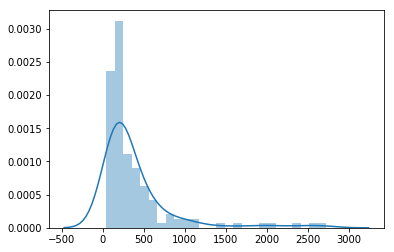

In [77]:
sns.distplot(out)

In [ ]:
label[label>3000]

In [ ]:
sns.distplot(label)

In [ ]:
sns.distplot(result['predict_quantity'])

In [ ]:
sns.distplot(tra['num_x'].dropna())

In [ ]:
sns.distplot(tra['num_y'].dropna())

In [ ]:
ou[impt['name']].fillna(-999)

In [ ]:
ou[3].shape

In [ ]:
tra.info()

In [ ]:
ou['num'].rank()

In [ ]:
obj = pd.Series([7,-5,7,4,2,0,4])
print (obj.rank(method='max'))

In [ ]:

col=list(ou.columns)
l=[b.startswith('num') for b in col ]

In [ ]:
ou.columns[l]

In [ ]:
np.min(ou1,axis=1)

In [ ]:
ou1.shape

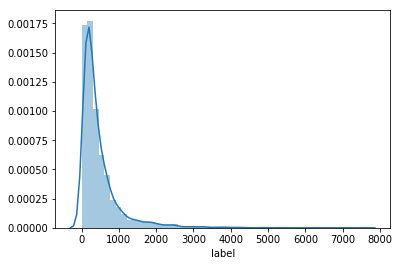

In [21]:
sns.distplot(ou['label'])